In [337]:
!pip install catboost

In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [339]:
train_file = pd.read_csv('https://drive.google.com/uc?id=16dGSp_T6FhylyckqWJEXQzUi5sZH0heW') ## train.csv
target_file = pd.read_csv('https://drive.google.com/uc?id=1QCZa0_m1WzW2OsJYzJXOWY4QFnvFFfmK') ## target.csv
test_file = pd.read_csv('https://drive.google.com/uc?id=18wzEa16ntCFSup1VSF028pGqoGayejuH') ## test.csv


# train_file = pd.read_csv('train.csv') ## train.csv
# target_file = pd.read_csv('target.csv') ## target.csv
# test_file = pd.read_csv('test.csv') ## test.csv

train_copy = train_file.copy() ## untuk perbandingan nanti
target_copy = target_file.copy() ## untuk perbandingan nanti
test_copy = test_file.copy() ## untuk perbandingan nanti


In [340]:
train = pd.concat([train_file,target_file["coppaRisk"]], axis =1)
train['coppaRisk'] = train['coppaRisk'].astype(int)
test = test_file.copy()

## Exploratory Data Analysis

In [341]:
# # Basic information
# print("Dataset shape:", train.shape)
# print("\nData types:")
# print(train.dtypes)

# # Missing values
# missing = train.isnull().sum()
# missing_percent = 100 * missing / len(train)
# missing_data = pd.DataFrame({'Missing Count': missing,
#                              'Missing Percent': missing_percent})
# print("\nMissing values:")
# print(missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Percent', ascending=False))

# # Target variable
# print("\nTarget variable distribution:")
# print(train['coppaRisk'].value_counts())
# print(100 * train['coppaRisk'].value_counts() / len(train))

# # Add numeric version of target for analysis
# train['coppaRisk_numeric'] = (train['coppaRisk'] == True).astype(int)

# # Numeric features basic stats
# numeric_cols = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']
# print("\nNumeric columns statistics:")
# print(train[numeric_cols].describe())

# # Skewness
# print("\nSkewness of numeric features:")
# print(train[numeric_cols].skew())

# # Enhanced categorical analysis
# categorical_cols = [
#     'developerCountry', 'countryCode', 'primaryGenreName', 'deviceType',
#     'hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating',
#     'appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating', 'mfaRating'
# ]

# print("\n" + "="*50)
# print("CATEGORICAL COLUMNS ANALYSIS")
# print("="*50)

# for col in categorical_cols:
#     unique_values = train[col].nunique()
#     missing = train[col].isnull().sum()
#     missing_percent = 100 * missing / len(train)

#     print(f"\n{col}:")
#     print(f"- Unique values: {unique_values}")
#     print(f"- Missing values: {missing} ({missing_percent:.2f}%)")
#     print(f"- Most common values:")

#     # Get value counts and percentages
#     value_counts = train[col].value_counts().head(5)
#     value_percents = 100 * train[col].value_counts(normalize=True).head(5)

#     # Display top 5 values with counts and percentages
#     for val, count, percent in zip(value_counts.index, value_counts, value_percents):
#         print(f"  {val}: {count} ({percent:.2f}%)")

#     # Calculate risk rate for each value
#     risk_by_value = train.groupby(col)['coppaRisk_numeric'].agg(['count', 'mean'])
#     risk_by_value = risk_by_value[risk_by_value['count'] >= 10]  # Min 10 samples
#     risk_by_value = risk_by_value.sort_values('mean', ascending=False)

#     print(f"- Top 10 values by COPPA risk rate (min 10 samples):")
#     for val, stats in risk_by_value.head(10).iterrows():
#         print(f"  {val}: {stats['mean']*100:.2f}% risk ({stats['count']} samples)")

# # Special handling for downloads
# print("\n" + "="*50)
# print("DOWNLOADS ANALYSIS")
# print("="*50)

# # Extract minimum downloads from ranges
# def extract_min_max(downloads_str):
#     if pd.isna(downloads_str):
#         return np.nan, np.nan
#     try:
#         parts = downloads_str.split(' - ')
#         return int(parts[0]), int(parts[1])
#     except:
#         return np.nan, np.nan

# # Apply extraction to non-null values
# download_min_max = train['downloads'].dropna().apply(lambda x: pd.Series(extract_min_max(x), index=['min', 'max']))
# train_with_downloads = train.join(download_min_max)

# print(f"\nUnique download ranges: {train['downloads'].nunique()}")

# # Print some of the unique download ranges
# unique_ranges = train['downloads'].dropna().unique()
# print("\nSample of download ranges:")
# # for range_val in sorted(unique_ranges)[:15]:  # Show first 15 sorted ranges
# for range_val in (unique_ranges):  # Show first 15 sorted ranges
#     print(f"  {range_val}")

# # Count occurrences of each range
# # range_counts = train['downloads'].value_counts().head(10)
# range_counts = train['downloads'].value_counts()
# print("\nMost common download ranges:")
# for range_val, count in range_counts.items():
#     print(f"  {range_val}: {count} occurrences")

# print(f"Missing download values: {train['downloads'].isnull().sum()} ({100*train['downloads'].isnull().sum()/len(train):.2f}%)")

# print("\nDistribution of minimum downloads:")
# min_downloads_bins = [0, 10, 100, 1000, 10000, 100000, float('inf')]
# min_downloads_labels = ['0-10', '11-100', '101-1K', '1K-10K', '10K-100K', '>100K']
# download_counts = pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels).value_counts().sort_index()
# download_percents = 100 * download_counts / download_counts.sum()

# for label, count, percent in zip(download_counts.index, download_counts, download_percents):
#     print(f"  {label}: {count} ({percent:.2f}%)")

# # Calculate COPPA risk by download range
# download_risk = train_with_downloads.groupby(pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels))['coppaRisk_numeric'].mean() * 100
# print("\nCOPPA risk by download range:")
# for label, risk in zip(download_risk.index, download_risk):
#     print(f"  {label}: {risk:.2f}% risk")

# # Cross-tabulation of key categorical features
# print("\n" + "="*50)
# print("CROSS-TABULATION ANALYSIS")
# print("="*50)

# # Genre and device type
# print("\nPrimary genres by device type (top 5 combinations):")
# genre_device = pd.crosstab(train['primaryGenreName'], train['deviceType'])
# print(genre_device.unstack().sort_values(ascending=False).head(5))

# # Genre and risk
# print("\nRisk rate by top genres and privacy policy:")
# top_genres = train['primaryGenreName'].value_counts().head(5).index
# genre_privacy_risk = train[train['primaryGenreName'].isin(top_genres)].groupby(['primaryGenreName', 'hasPrivacyLink'])['coppaRisk_numeric'].agg(['count', 'mean'])
# print(genre_privacy_risk.sort_values(by=['primaryGenreName', 'mean'], ascending=[True, False]))

# # Feature importance estimation using mutual information
# print("\n" + "="*50)
# print("FEATURE IMPORTANCE ESTIMATION")
# print("="*50)

# try:
#     from sklearn.feature_selection import mutual_info_classif

#     # Prepare data for feature importance
#     features_for_mi = train[numeric_cols].copy()
#     for col in features_for_mi.columns:
#         features_for_mi[col] = features_for_mi[col].fillna(features_for_mi[col].median())

#     # Calculate mutual information
#     mi_scores = mutual_info_classif(features_for_mi, train['coppaRisk_numeric'])
#     mi_results = pd.Series(mi_scores, index=features_for_mi.columns)

#     print("\nFeature importance by mutual information:")
#     for feature, score in mi_results.sort_values(ascending=False).items():
#         print(f"  {feature}: {score:.4f}")
# except:
#     print("\nSkikit-learn not available for mutual information calculation")

In [342]:
# # Check unique values first
# print("Unique values in coppaRisk column:", train['coppaRisk'].unique())

# # Convert to numeric properly
# train['coppaRisk_numeric'] = (train['coppaRisk'] == True).astype(int)

# # Verify our conversion worked
# print("\nTarget distribution after conversion:")
# print(train['coppaRisk_numeric'].value_counts())
# print(f"Percentage of True: {100 * train['coppaRisk_numeric'].mean():.2f}%")

# # 1. Missing values visualization
# missing = train.isnull().sum().sort_values(ascending=False)
# missing_percent = 100 * missing / len(train)
# missing_df = pd.DataFrame({'Missing Count': missing, 'Missing Percent': missing_percent})
# missing_df = missing_df[missing_df['Missing Count'] > 0]

# plt.figure(figsize=(12, 6))
# ax = sns.barplot(x=missing_df.index, y='Missing Percent', data=missing_df)
# plt.title('Percentage of Missing Values by Column')
# plt.xticks(rotation=90)
# plt.ylabel('Percent Missing')
# plt.tight_layout()
# plt.show()

# # 2. Target variable distribution
# plt.figure(figsize=(8, 5))
# ax = sns.countplot(x='coppaRisk', data=train)
# plt.title('Distribution of COPPA Risk (Target Variable)')

# # Add percentage labels
# total = len(train)
# for i, p in enumerate(ax.patches):
#     percentage = f'{100 * p.get_height() / total:.1f}%'
#     ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
#                 ha='center', va='bottom')
# plt.tight_layout()
# plt.show()

# # 3. Correlation matrix - fixed to show all correlations including target
# numeric_cols = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']
# # Add target to the list
# cols_with_target = numeric_cols + ['coppaRisk_numeric']

# # Fill missing values for correlation calculation only
# corr_df = train[cols_with_target].copy()
# for col in numeric_cols:
#     corr_df[col] = corr_df[col].fillna(corr_df[col].median())

# corr_matrix = corr_df.corr()
# print("\nCorrelation matrix with target:")
# print(corr_matrix['coppaRisk_numeric'].sort_values(ascending=False))

# # Plot full correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Correlation Matrix of Numeric Features')
# plt.tight_layout()
# plt.show()

# # 4. Bar chart of feature correlations with target
# plt.figure(figsize=(10, 6))
# target_corrs = corr_matrix['coppaRisk_numeric'].drop('coppaRisk_numeric').sort_values(ascending=False)
# ax = sns.barplot(x=target_corrs.index, y=target_corrs.values)
# plt.title('Feature Correlations with COPPA Risk')
# plt.xticks(rotation=45)
# plt.ylabel('Correlation Coefficient')
# plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# # Add correlation values as text
# for i, v in enumerate(target_corrs.values):
#     ax.text(i, v + 0.01 if v >= 0 else v - 0.03, f"{v:.2f}", ha='center')

# plt.tight_layout()
# plt.show()

# # 5. Genre vs COPPA risk - FIXED
# # Calculate risk rate by genre properly
# genre_risk = train.groupby('primaryGenreName')['coppaRisk_numeric'].agg(['count', 'mean'])
# genre_risk = genre_risk[genre_risk['count'] >= 20]  # Min 20 apps per genre
# genre_risk = genre_risk.sort_values('mean', ascending=False)
# genre_risk['mean'] = genre_risk['mean'] * 100  # Convert to percentage

# print("\nCOPPA risk rate by genre (min 20 apps):")
# print(genre_risk.head(10))

# plt.figure(figsize=(14, 7))
# ax = sns.barplot(x=genre_risk.index[:10], y='mean', data=genre_risk[:10])
# plt.title('COPPA Risk Rate by Genre (min 20 apps)')
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('Risk Rate (%)')

# # Add percentage labels
# for i, v in enumerate(genre_risk['mean'][:10]):
#     ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

# plt.tight_layout()
# plt.show()

# # 6. Privacy policy vs COPPA risk - FIXED
# privacy_risk = train.groupby('hasPrivacyLink')['coppaRisk_numeric'].agg(['count', 'mean'])
# privacy_risk['mean'] = privacy_risk['mean'] * 100  # Convert to percentage

# print("\nCOPPA risk by privacy policy presence:")
# print(privacy_risk)

# plt.figure(figsize=(8, 5))
# ax = sns.barplot(x=privacy_risk.index, y='mean', data=privacy_risk)
# plt.title('COPPA Risk Rate by Privacy Policy Presence')
# plt.ylabel('Risk Rate (%)')

# # Add percentage labels
# for i, v in enumerate(privacy_risk['mean']):
#     ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

# plt.tight_layout()
# plt.show()

# # 7. Box plots for key numerical features
# for col in ['userRatingCount', 'isCorporateEmailScore', 'appAge', 'averageUserRating']:
#     plt.figure(figsize=(10, 6))
#     ax = sns.boxplot(x='coppaRisk', y=col, data=train)
#     plt.title(f'{col} by COPPA Risk Status')
#     # For very skewed features, use log scale
#     if train[col].skew() > 5 and (train[col] > 0).all():
#         plt.yscale('log')
#         plt.ylabel(f'{col} (log scale)')
#     plt.tight_layout()
#     plt.show()

# # 8. Distribution of downloads (min range)
# if 'downloads' in train.columns:
#     # Extract minimum downloads from the range
#     def extract_min(downloads_str):
#         if pd.isna(downloads_str):
#             return np.nan
#         try:
#             return int(downloads_str.split(' - ')[0])
#         except:
#             return np.nan

#     train['min_downloads'] = train['downloads'].apply(extract_min)

#     plt.figure(figsize=(12, 6))
#     ax = sns.boxplot(x='coppaRisk', y='min_downloads', data=train)
#     plt.title('Minimum Downloads by COPPA Risk')
#     plt.yscale('log')
#     plt.ylabel('Minimum Downloads (log scale)')
#     plt.tight_layout()
#     plt.show()

#     # Calculate COPPA risk by download range (binned)
#     def categorize_downloads(min_val):
#         if pd.isna(min_val):
#             return 'Unknown'
#         elif min_val < 100:
#             return '<100'
#         elif min_val < 1000:
#             return '100-1K'
#         elif min_val < 10000:
#             return '1K-10K'
#         elif min_val < 100000:
#             return '10K-100K'
#         else:
#             return '>100K'

#     train['download_bin'] = train['min_downloads'].apply(categorize_downloads)

#     download_risk = train.groupby('download_bin')['coppaRisk_numeric'].agg(['count', 'mean'])
#     download_risk = download_risk[download_risk['count'] >= 20]
#     download_risk['mean'] = download_risk['mean'] * 100

#     plt.figure(figsize=(10, 6))
#     ax = sns.barplot(x=download_risk.index, y='mean', data=download_risk)
#     plt.title('COPPA Risk Rate by Download Range')
#     plt.ylabel('Risk Rate (%)')

#     # Add percentage labels
#     for i, v in enumerate(download_risk['mean']):
#         ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

#     plt.tight_layout()
#     plt.show()

In [343]:
# # only use for visualization
# train = train.drop(['download_bin', 'coppaRisk_numeric','min_downloads'], axis=1, errors='ignore')

In [344]:
def analyze_raw_features(df, target_column='coppaRisk', categorical_threshold=10, top_n=10,
                        high_missing_threshold=0.3):
    """
    Analyze raw features in the original dataframe to identify which are most predictive

    Parameters:
    -----------
    df : DataFrame
        Original dataframe with features and target
    target_column : str, default='coppaRisk'
        Name of the target column
    categorical_threshold : int, default=10
        Max unique values to consider a feature categorical
    top_n : int, default=10
        Number of top features to display
    high_missing_threshold : float, default=0.3
        Threshold to flag features with high missing values (30% by default)

    Returns:
    --------
    dict
        Dictionary with analysis results
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from scipy import stats

    print(f"\n{'='*60}")
    print("RAW FEATURE ANALYSIS")
    print(f"{'='*60}")

    # Extract target and features
    y = df[target_column]
    X = df.drop(columns=[target_column])

    # Analyze missing values first
    print(f"\n{'='*30} MISSING VALUES ANALYSIS {'='*30}")
    missing_analysis = {}
    features_with_high_missing = []

    print(f"{'Feature':<30} {'Missing Count':<15} {'Missing %':<15} {'Status':<15}")
    print("-" * 75)

    for col in X.columns:
        missing_count = X[col].isnull().sum()
        missing_pct = missing_count / len(X) * 100
        status = "High Missing" if missing_pct >= high_missing_threshold * 100 else "OK"

        if missing_pct >= high_missing_threshold * 100:
            features_with_high_missing.append(col)

        missing_analysis[col] = {
            'missing_count': missing_count,
            'missing_pct': missing_pct,
            'is_high_missing': missing_pct >= high_missing_threshold * 100
        }

        print(f"{col:<30} {missing_count:<15} {missing_pct:>10.2f}% {'⚠️ ' + status if status != 'OK' else status:<15}")

    print(f"\nFound {len(features_with_high_missing)} features with high missing values (>{high_missing_threshold*100}%)")
    if features_with_high_missing:
        print("Features with high missing values: " + ", ".join(features_with_high_missing))

    # Separate categorical and numerical features
    categorical_features = []
    numerical_features = []

    for col in X.columns:
        if X[col].nunique() <= categorical_threshold:
            categorical_features.append(col)
        elif pd.api.types.is_numeric_dtype(X[col]):
            numerical_features.append(col)

    print(f"\nFound {len(categorical_features)} categorical features and {len(numerical_features)} numerical features")

    # Initialize storage for results
    analysis_results = {
        'missing_analysis': missing_analysis,
        'features_with_high_missing': features_with_high_missing,
        'numerical_importance': {},
        'categorical_importance': {},
        'most_important_features': []
    }

    # Analyze numerical features
    print(f"\n{'='*30} NUMERICAL FEATURES {'='*30}")
    numerical_importance = {}

    for col in numerical_features:
        # Skip if all values are missing
        if X[col].isna().all():
            continue

        # Get missing percentage for this feature
        missing_pct = missing_analysis[col]['missing_pct']

        # Basic statistics by class
        class_0_data = X[col][y == 0].dropna()
        class_1_data = X[col][y == 1].dropna()

        if len(class_0_data) == 0 or len(class_1_data) == 0:
            continue

        class_0_mean = class_0_data.mean()
        class_1_mean = class_1_data.mean()
        mean_diff = abs(class_1_mean - class_0_mean)
        mean_diff_pct = mean_diff / max(abs(class_0_mean), 1e-10) * 100

        # Perform t-test
        try:
            t_stat, p_value = stats.ttest_ind(class_0_data, class_1_data, equal_var=False)
            is_significant = p_value < 0.05
        except:
            p_value = 1.0
            is_significant = False

        # Calculate point-biserial correlation (correlation with binary target)
        valid_indices = ~X[col].isna()
        if valid_indices.sum() > 0:
            correlation = stats.pointbiserialr(y[valid_indices], X[col][valid_indices])[0]
        else:
            correlation = 0

        # Calculate reliability-adjusted importance (penalize high missing values)
        reliability_factor = max(0, 1 - (missing_pct / 100) * 2)  # Linear penalty
        importance_score = abs(correlation) * reliability_factor

        numerical_importance[col] = importance_score

        # Store in results
        analysis_results['numerical_importance'][col] = {
            'correlation': correlation,
            'p_value': p_value,
            'class_0_mean': class_0_mean,
            'class_1_mean': class_1_mean,
            'mean_diff_pct': mean_diff_pct,
            'is_significant': is_significant,
            'missing_pct': missing_pct,
            'reliability_factor': reliability_factor,
            'importance_score': importance_score
        }

    # Sort numerical features by reliability-adjusted importance
    sorted_numerical = sorted(numerical_importance.items(), key=lambda x: x[1], reverse=True)

    # Display top numerical features
    print(f"\nTop {min(top_n, len(sorted_numerical))} Numerical Features (Reliability-Adjusted):")
    print(f"{'Feature':<25} {'Correlation':<13} {'Missing %':<10} {'Adj.Importance':<15}")
    print("-" * 70)

    for feature, score in sorted_numerical[:top_n]:
        result = analysis_results['numerical_importance'][feature]
        missing_warning = "⚠️ " if result['missing_pct'] >= high_missing_threshold * 100 else ""
        print(f"{feature:<25} {result['correlation']:>+.4f}{'*' if result['is_significant'] else ' ':>6} "
              f"{missing_warning}{result['missing_pct']:>7.1f}% {result['importance_score']:>13.4f}")

    # Analyze categorical features
    print(f"\n{'='*30} CATEGORICAL FEATURES {'='*30}")
    categorical_importance = {}

    for col in categorical_features:
        # Skip if all values are missing
        if X[col].isna().all():
            continue

        # Get missing percentage for this feature
        missing_pct = missing_analysis[col]['missing_pct']

        # Calculate risk rates by category
        risk_rates = {}
        entropy = 0
        information_gain = 0

        # Fill missing values with a placeholder for this analysis
        temp_col = X[col].fillna('MISSING')

        # Overall risk rate (class 1 proportion)
        overall_risk_rate = y.mean()

        # Calculate risk rate and information gain for each category
        for category in temp_col.unique():
            mask = temp_col == category
            category_count = mask.sum()

            if category_count > 0:
                category_risk = y[mask].mean()
                risk_rates[category] = {
                    'count': category_count,
                    'percentage': 100 * category_count / len(temp_col),
                    'risk_rate': category_risk
                }

                # Calculate contribution to information gain
                p = category_count / len(temp_col)
                if 0 < category_risk < 1:  # Avoid log(0)
                    category_entropy = -(category_risk * np.log2(category_risk) +
                                        (1-category_risk) * np.log2(1-category_risk))
                    entropy += p * category_entropy

                # Add to information gain based on divergence from overall risk
                information_gain += p * abs(category_risk - overall_risk_rate)

        # Chi-square test
        try:
            contingency = pd.crosstab(temp_col, y)
            chi2, p_value, _, _ = stats.chi2_contingency(contingency)
            is_significant = p_value < 0.05
        except:
            chi2, p_value = 0, 1.0
            is_significant = False

        # Calculate Cramer's V (normalized measure of association)
        try:
            n = len(temp_col)
            phi2 = chi2 / n
            r, k = contingency.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        except:
            cramers_v = 0

        # Calculate reliability-adjusted importance (penalize high missing values)
        reliability_factor = max(0, 1 - (missing_pct / 100) * 2)  # Linear penalty
        importance_score = information_gain * reliability_factor

        categorical_importance[col] = importance_score

        # Store in results
        analysis_results['categorical_importance'][col] = {
            'risk_rates': risk_rates,
            'chi2': chi2,
            'p_value': p_value,
            'is_significant': is_significant,
            'cramers_v': cramers_v,
            'information_gain': information_gain,
            'missing_pct': missing_pct,
            'reliability_factor': reliability_factor,
            'importance_score': importance_score
        }

    # Sort categorical features by reliability-adjusted importance
    sorted_categorical = sorted(categorical_importance.items(), key=lambda x: x[1], reverse=True)

    # Display top categorical features
    print(f"\nTop {min(top_n, len(sorted_categorical))} Categorical Features (Reliability-Adjusted):")
    print(f"{'Feature':<25} {'Info Gain':<10} {'Missing %':<10} {'Adj.Importance':<15}")
    print("-" * 70)

    for feature, score in sorted_categorical[:top_n]:
        result = analysis_results['categorical_importance'][feature]
        missing_warning = "⚠️ " if result['missing_pct'] >= high_missing_threshold * 100 else ""
        print(f"{feature:<25} {result['information_gain']:>7.4f}{'*' if result['is_significant'] else ' ':>3} "
              f"{missing_warning}{result['missing_pct']:>7.1f}% {result['importance_score']:>13.4f}")

        # Display top categories for the feature
        sorted_categories = sorted(result['risk_rates'].items(),
                                  key=lambda x: (x[1]['count'], -x[1]['risk_rate']), reverse=True)

        print("\n  Top categories by count (with risk rates):")
        print(f"  {'Category':<20} {'Count':<10} {'Percentage':<15} {'Risk Rate':<15}")
        print("  " + "-" * 60)

        for category, stats in sorted_categories[:3]:
            print(f"  {str(category)[:20]:<20} {stats['count']:<10} "
                  f"{stats['percentage']:>12.2f}% {stats['risk_rate']:>12.4f}")
        print("")

    # Combine numerical and categorical importance
    all_importances = {}
    all_importances.update(numerical_importance)
    all_importances.update(categorical_importance)

    # Get most important features overall
    most_important = sorted(all_importances.items(), key=lambda x: x[1], reverse=True)
    analysis_results['most_important_features'] = most_important

    # Display overall most important features
    print(f"\n{'='*30} OVERALL MOST IMPORTANT FEATURES {'='*30}")
    print(f"{'Feature':<25} {'Adj.Importance':<15} {'Type':<12} {'Missing %':<10}")
    print("-" * 70)

    for feature, score in most_important[:top_n]:
        feature_type = "Categorical" if feature in categorical_features else "Numerical"
        missing_pct = missing_analysis[feature]['missing_pct']
        missing_warning = "⚠️ " if missing_pct >= high_missing_threshold * 100 else ""
        print(f"{feature:<25} {score:>15.4f} {feature_type:<12} {missing_warning}{missing_pct:>7.1f}%")

    # Add plot for top 5 features
    plt.figure(figsize=(15, 10))

    for i, (feature, _) in enumerate(most_important[:5]):
        plt.subplot(2, 3, i+1)

        # Add title with missing value info
        missing_pct = missing_analysis[feature]['missing_pct']
        title_text = f"{feature}\n(Missing: {missing_pct:.1f}%)"

        if feature in numerical_features:
            # Numerical feature
            # Create histograms by class
            plt.hist(X[feature][y == 0].dropna(), alpha=0.5, label='Not COPPA Risk')
            plt.hist(X[feature][y == 1].dropna(), alpha=0.5, label='COPPA Risk')
            plt.title(title_text)
            plt.legend()
        else:
            # Categorical feature
            # Get risk rates from analysis
            risk_rates = analysis_results['categorical_importance'][feature]['risk_rates']
            categories = []
            rates = []

            # Get top categories by count
            sorted_by_count = sorted(risk_rates.items(),
                                    key=lambda x: x[1]['count'], reverse=True)

            for category, stats in sorted_by_count[:7]:  # Top 7 categories
                categories.append(str(category))
                rates.append(stats['risk_rate'])

            # Create bar chart
            plt.bar(categories, rates)
            plt.title(title_text)
            plt.xticks(rotation=45, ha='right')
            plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    return analysis_results


RAW FEATURE ANALYSIS

============================== MISSING VALUES ANALYSIS ==============================
Feature                        Missing Count   Missing %       Status         
---------------------------------------------------------------------------
developerCountry               0                     0.00% OK             
countryCode                    64                    0.91% OK             
userRatingCount                0                     0.00% OK             
primaryGenreName               0                     0.00% OK             
downloads                      2149                 30.70% ⚠️ High Missing
deviceType                     0                     0.00% OK             
hasPrivacyLink                 750                  10.71% OK             
hasTermsOfServiceLink          4635                 66.21% ⚠️ High Missing
hasTermsOfServiceLinkRating    4635                 66.21% ⚠️ High Missing
isCorporateEmailScore          1128                 16.11% OK

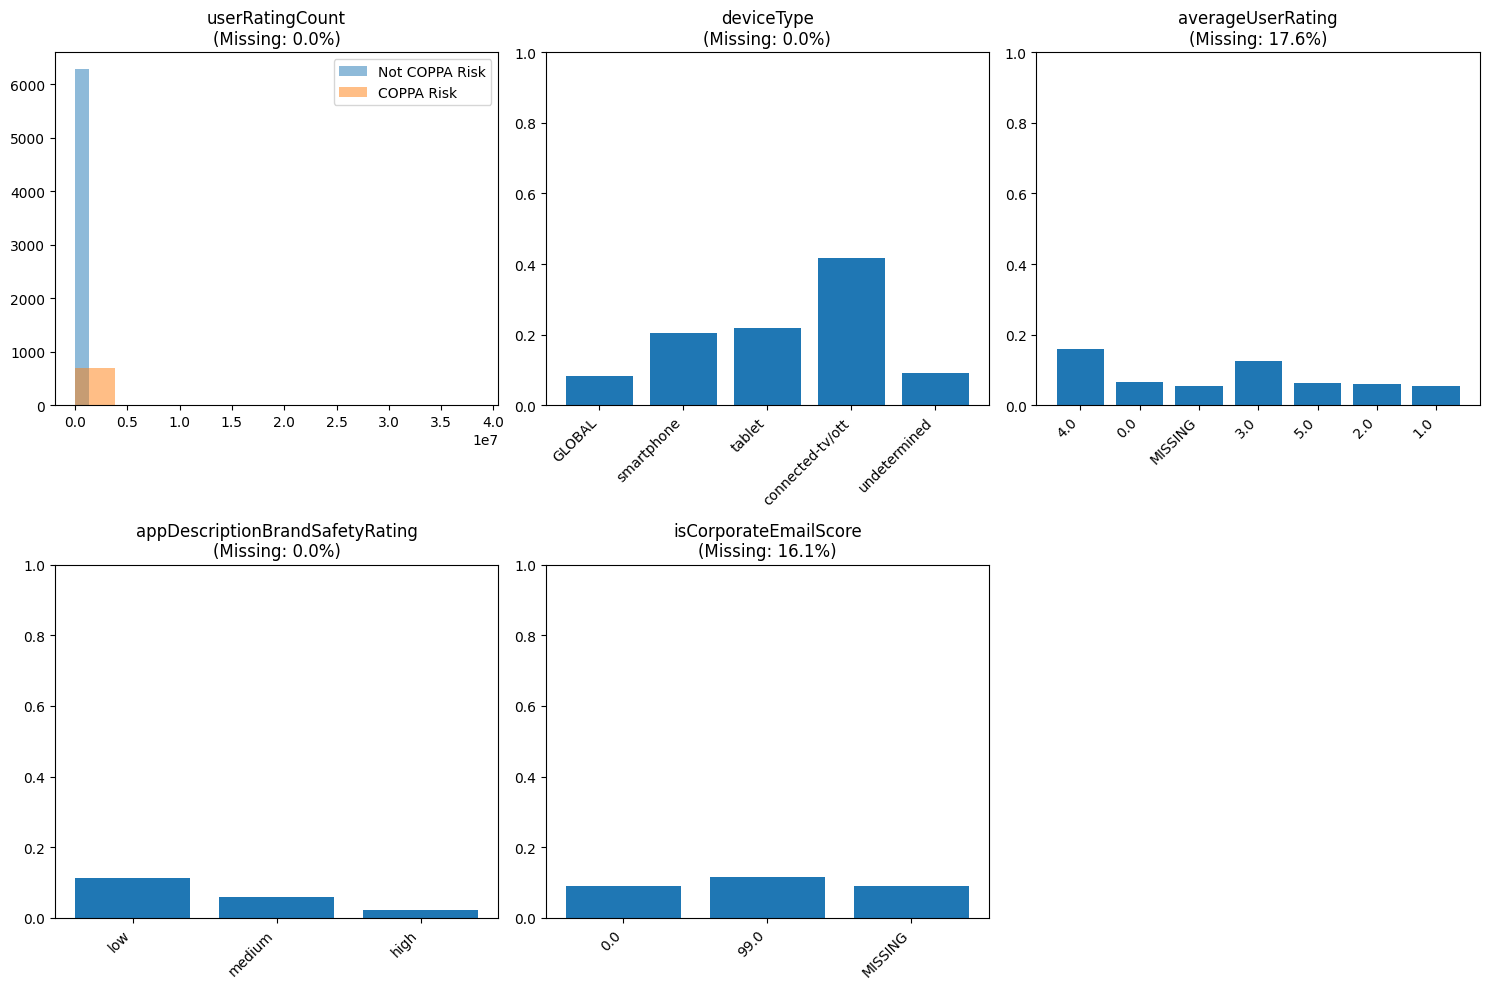

In [345]:
raw_analysis = analyze_raw_features(train, 'coppaRisk')

## 1. Split Training & Validation Set

In [346]:
from sklearn.model_selection import  train_test_split

train_set, val_set = train_test_split(train, stratify=train['coppaRisk'], test_size=0.2, random_state=42)

## 2. Data Cleaning & Preprocessing

### A. Data Cleaning

In [347]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

#### I. Handling Missing Data

In [348]:
def analyze_imputation_strategies(df, verbose=True):
    """
    Analyze each feature in the dataframe and recommend appropriate imputation strategies.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset to analyze
    verbose : bool, default=True
        Whether to print detailed analysis

    Returns:
    --------
    dict
        Dictionary with column names as keys and recommended strategies as values
    """
    # Dictionary to store recommended strategies
    recommended_strategies = {}

    # Function to print section headers for readability
    def print_section(title):
        if verbose:
            print("\n" + "="*50)
            print(title)
            print("="*50)

    print_section("ANALYZING IMPUTATION STRATEGIES")

    # Analyze each column
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        missing_percent = 100 * missing_count / len(df)

        # Skip columns with no missing values
        if missing_count == 0:
            recommended_strategies[column] = 'no_missing_values'
            if verbose:
                print(f"\n{column}: No missing values")
            continue

        # Handle columns with very high missing percentages
        if missing_percent > 50:
            recommended_strategies[column] = 'drop_column'
            if verbose:
                print(f"\n{column}: HIGH MISSING DATA ({missing_percent:.2f}%)")
                print(f"  - Recommendation: Drop column")
            continue

        # Check column type
        col_type = df[column].dtype

        if verbose:
            print(f"\n{column}: {missing_count} missing values ({missing_percent:.2f}%)")
            print(f"  - Data type: {col_type}")

        # For numeric columns
        if np.issubdtype(col_type, np.number):
            # Calculate statistics
            non_missing = df[column].dropna()

            if len(non_missing) == 0:
                recommended_strategies[column] = 'drop_column'
                if verbose:
                    print(f"  - All values are missing")
                    print(f"  - Recommendation: Drop column")
                continue

            mean_val = non_missing.mean()
            median_val = non_missing.median()
            mode_val = non_missing.mode()[0]
            skew = non_missing.skew()

            if verbose:
                print(f"  - Mean: {mean_val:.4f}")
                print(f"  - Median: {median_val:.4f}")
                print(f"  - Mode: {mode_val}")
                print(f"  - Skewness: {skew:.4f}")

            # Check distribution
            if abs(skew) > 1:
                # For skewed distributions, median is usually better
                recommended_strategies[column] = 'median'
                if verbose:
                    print(f"  - Recommendation: Median imputation (skewed distribution)")
            else:
                # For normal distributions, mean might be better
                recommended_strategies[column] = 'mean'
                if verbose:
                    print(f"  - Recommendation: Mean imputation (normal distribution)")

            # Special case for userRatingCount or similar metrics that might be 0 by design
            if 'count' in column.lower() and median_val == 0:
                recommended_strategies[column] = 'constant_0'
                if verbose:
                    print(f"  - Special recommendation: Constant 0 (count-like variable)")

        # For categorical columns
        elif pd.api.types.is_object_dtype(col_type) or pd.api.types.is_bool_dtype(col_type):
            # Get value counts
            value_counts = df[column].value_counts(normalize=True, dropna=False)
            top_values = value_counts.head(3)

            if verbose:
                print(f"  - Value distribution (top 3):")
                for val, freq in top_values.items():
                    if pd.isna(val):
                        continue
                    print(f"      {val}: {freq*100:.2f}%")

            # Special handling for developerCountry
            if column == 'developerCountry':
                # If the column contains placeholder values for missing information
                if any(val in ['ADDRESS NOT LISTED IN PLAYSTORE', 'CANNOT IDENTIFY COUNTRY']
                      for val in df[column].unique()):
                    recommended_strategies[column] = 'custom_placeholder'
                    if verbose:
                        print(f"  - Special recommendation: Use 'UNKNOWN' (already contains placeholder values)")

            # Check if a value is highly dominant
            elif value_counts.iloc[0] > 0.8:
                recommended_strategies[column] = 'most_frequent'
                if verbose:
                    print(f"  - Recommendation: Most frequent imputation (dominant category)")
            else:
                # For more balanced distributions, still use most frequent but note it
                recommended_strategies[column] = 'most_frequent'
                if verbose:
                    print(f"  - Recommendation: Most frequent imputation")

            # Special case for boolean-like features
            if len(value_counts) == 2:
                if verbose:
                    print(f"  - Note: Binary feature - most frequent imputation suitable")

        # Handle special columns
        if column == 'downloads':
            recommended_strategies[column] = 'custom_downloads'
            if verbose:
                print(f"  - Special recommendation: Custom handling for downloads range")

    # Summarize recommendations
    print_section("SUMMARY OF RECOMMENDATIONS")
    strategy_counts = {}

    for col, strategy in recommended_strategies.items():
        if strategy not in strategy_counts:
            strategy_counts[strategy] = 0
        strategy_counts[strategy] += 1

        if verbose:
            print(f"{col}: {strategy}")

    if verbose:
        print("\nStrategy distribution:")
        for strategy, count in strategy_counts.items():
            print(f"  {strategy}: {count} columns")

    return recommended_strategies

In [349]:
class FeatureCleaner(BaseEstimator, TransformerMixin):
    """
    Handle missing data with adaptive strategies for each column
    """
    def __init__(self, analyze_first=True, create_indicators=True, process_downloads=True):
        self.analyze_first = analyze_first
        self.create_indicators = create_indicators
        self.process_downloads = process_downloads
        self.strategy_dict = {}

    def _process_downloads(self, df):
        """
        Process download ranges into min, max, and category
        """
        result_df = df.copy()

        def extract_min_max(download_str):
            if pd.isna(download_str):
                return np.nan, np.nan
            try:
                parts = download_str.split(' - ')
                if len(parts) == 2:
                    val1 = int(parts[0])
                    val2 = int(parts[1])
                    # make sure min is always smaller value
                    min_val = min(val1, val2)
                    max_val = max(val1, val2)
                    return min_val, max_val
                else:
                    return np.nan, np.nan
            except:
                return np.nan, np.nan

        # Apply extraction and create new columns
        result_df['min_downloads'] = result_df['downloads'].apply(lambda x: extract_min_max(x)[0] if not pd.isna(x) else np.nan)
        result_df['max_downloads'] = result_df['downloads'].apply(lambda x: extract_min_max(x)[1] if not pd.isna(x) else np.nan)
        result_df['avg_downloads'] = (result_df['min_downloads'] + result_df['max_downloads']) / 2

        def categorize_downloads(min_val):
            if pd.isna(min_val):
                return 'Unknown'
            elif min_val < 100:
                return '<100'
            elif min_val < 1000:
                return '100-1K'
            elif min_val < 10000:
                return '1K-10K'
            elif min_val < 100000:
                return '10K-100K'
            else:
                return '>100K'

        result_df['download_category'] = result_df['min_downloads'].apply(categorize_downloads)
        result_df = result_df.drop(columns=['downloads'])
        self.download_cols_ = ['min_downloads', 'max_downloads', 'avg_downloads']
        return result_df

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()

        # Process downloads if requested
        if self.process_downloads and 'downloads' in X.columns:
            X = self._process_downloads(X)

            # Update strategy for new download columns
            if hasattr(self, 'download_cols_'):
                for col in self.download_cols_:
                    self.strategy_dict[col] = 'median'

        # Analyze imputation strategies if requested
        if self.analyze_first:
            self.strategy_dict = analyze_imputation_strategies(X, verbose=True)

        # Separate numeric and categorical columns
        self.numeric_cols_ = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.categorical_cols_ = X.select_dtypes(include=['object', 'bool']).columns.tolist()

        # Get columns to drop (high missing %)
        self.cols_to_drop_ = [col for col, strategy in self.strategy_dict.items()
                             if strategy == 'drop_column']

        # Remove drop columns from imputation lists
        for col in self.cols_to_drop_:
            if col in self.numeric_cols_:
                self.numeric_cols_.remove(col)
            elif col in self.categorical_cols_:
                self.categorical_cols_.remove(col)

        # Create imputers for each type
        self.mean_imputer_ = SimpleImputer(strategy='mean')
        self.median_imputer_ = SimpleImputer(strategy='median')
        self.cat_imputer_ = SimpleImputer(strategy='most_frequent')

        # Split columns by strategy
        self.mean_cols_ = [col for col in self.numeric_cols_ if self.strategy_dict.get(col) == 'mean']
        self.median_cols_ = [col for col in self.numeric_cols_ if col not in self.mean_cols_]

        # Fit imputers
        if self.mean_cols_:
            self.mean_imputer_.fit(X[self.mean_cols_])
        if self.median_cols_:
            self.median_imputer_.fit(X[self.median_cols_])
        if self.categorical_cols_:
            self.cat_imputer_.fit(X[self.categorical_cols_])

        # Track columns with missing values for indicators
        if self.create_indicators:
            self.missing_cols_ = [col for col in X.columns
                                 if X[col].isnull().sum() > 0
                                 and col not in self.cols_to_drop_]

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        # Process downloads
        if self.process_downloads and 'downloads' in X.columns:
            X = self._process_downloads(X)

        # Create missing indicators
        if self.create_indicators and hasattr(self, 'missing_cols_'):
            for col in self.missing_cols_:
                if col in X.columns:
                    X[f'{col}_missing'] = X[col].isnull().astype(int)


        # if 'isCorporateEmailScore' in X.columns:
        #     # Special imputation for this important feature
        #     score_median = X['isCorporateEmailScore'].median()
        #     X['isCorporateEmailScore'] = X['isCorporateEmailScore'].fillna(score_median)

        # Apply special case for constant 0 imputation
        for col in self.numeric_cols_:
            if col in X.columns and self.strategy_dict.get(col) == 'constant_0':
                X[col] = X[col].fillna(0)

        # Apply mean imputation
        mean_cols_present = [col for col in self.mean_cols_ if col in X.columns]
        if mean_cols_present:
            X[mean_cols_present] = self.mean_imputer_.transform(X[mean_cols_present])

        # Apply median imputation
        median_cols_present = [col for col in self.median_cols_ if col in X.columns]
        if median_cols_present:
            X[median_cols_present] = self.median_imputer_.transform(X[median_cols_present])

        # Apply categorical imputation
        cat_cols_present = [col for col in self.categorical_cols_ if col in X.columns]
        if cat_cols_present:
            X[cat_cols_present] = self.cat_imputer_.transform(X[cat_cols_present])

        # Special handling for custom strategies (formerly in AdaptiveImputer)
        for col, strategy in self.strategy_dict.items():
            if col not in X.columns:
                continue

            if strategy == 'custom_placeholder' and pd.isna(X[col]).any():
                X[col] = X[col].fillna('UNKNOWN')

        # Drop columns with high missing %
        X = X.drop(columns=self.cols_to_drop_, errors='ignore')

        return X

In [350]:
# ? testing
# analyze_imputation_strategies(train)

#### II. Dealing with Outliers

In [351]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer

In [352]:
class FeatureTransformator(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0, target_column='coppaRisk'):

        self.skew_threshold = skew_threshold
        self.target_column = target_column

        self.log1p_cols_ = []
        self.power_transformers_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        for col in X.select_dtypes(include=[np.number]).columns:
            if col == self.target_column:
                continue

            skewness = X[col].skew()
            if abs(skewness) > self.skew_threshold:
                if skewness > 0:
                    self.log1p_cols_.append(col)
                else:
                    pt = PowerTransformer(method='yeo-johnson')

                    pt.fit(X[col].values.reshape(-1, 1))

                    self.power_transformers_[col] = pt

        return self

    # def transform(self, X):
    #     X = pd.DataFrame(X).copy()

    #     for col in self.log1p_cols_:
    #         if col in X.columns:
    #             X[col] = np.log1p(X[col])

    #     for col, pt in self.power_transformers_.items():
    #         if col in X.columns:
    #             X[col] = pt.transform(X[col].values.reshape(-1, 1)).flatten()

    #     return X

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in self.log1p_cols_:
            if col in X.columns:
                # Handle zero or negative values before log transform
                X[col] = np.maximum(X[col], 0)  # Ensure no negative values
                X[col] = np.log1p(X[col])

        for col, pt in self.power_transformers_.items():
            if col in X.columns:
                X[col] = pt.transform(X[col].values.reshape(-1, 1)).flatten()

        return X

#### III. Remove Duplicates

In [353]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def fit(self, X, y=None):
        # No fitting needed for duplicate removal
        return self

    def transform(self, X):
        X = X.copy() # Work on a copy

        before_len = len(X)
        # Drop duplicates, keeping the original index for the remaining rows
        X.drop_duplicates(inplace=True)
        after_len = len(X)

        # REMOVED THIS LINE: X.reset_index(drop=True, inplace=True)

        if self.verbose:
            print(f"DuplicateRemover: Before dropping duplicates: {before_len}")
            print(f"DuplicateRemover: After dropping duplicates:  {after_len}")
            print(f"DuplicateRemover: Shape after dropping: {X.shape}") # Optional: confirm shape

        return X


#### IV. Feature Engineering

In [354]:
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureDropper(BaseEstimator, TransformerMixin):
    """
    Drops a predefined list of features.

    Parameters:
    -----------
    cols_to_drop : list of str, optional (default=None)
        A list of column names to drop explicitly.

    verbose : bool, optional (default=True)
        If True, prints the columns being dropped.
    """
    def __init__(self, cols_to_drop=None, verbose=True):
        # Store the list of columns to drop provided during initialization
        self.cols_to_drop = cols_to_drop if cols_to_drop is not None else []
        self.verbose = verbose
        # This attribute will store the final list after fit (which is just self.cols_to_drop)
        self.final_cols_to_drop_ = []

    def fit(self, X, y=None):
        """
        Stores the list of columns to be dropped.

        Parameters:
        -----------
        X : pd.DataFrame
            Input features (used to check column existence, but not for calculations).
        y : pd.Series or np.array, optional
            Target variable (ignored).

        Returns:
        --------
        self : object
            Returns the instance itself.
        """
        # Simply assign the predefined list
        self.final_cols_to_drop_ = self.cols_to_drop

        if self.verbose:
            print(f"FeatureDropper initialized to drop: {sorted(self.final_cols_to_drop_)}")

        return self

    def transform(self, X):
        """
        Drops the specified columns from the DataFrame.

        Parameters:
        -----------
        X : pd.DataFrame
            Input features.

        Returns:
        --------
        pd.DataFrame
            DataFrame with specified columns dropped.
        """
        X_ = X.copy()

        # Check if fit has been called (although fit is very simple now)
        if not hasattr(self, 'final_cols_to_drop_'):
             raise RuntimeError("This FeatureDropper instance is not fitted yet. Call 'fit' before using 'transform'.")

        # Identify which columns to drop are actually present in X
        cols_present_to_drop = [col for col in self.final_cols_to_drop_ if col in X_.columns]

        if not cols_present_to_drop:
             if self.verbose:
                 print("FeatureDropper: No columns from the drop list found in the input DataFrame.")
             return X_

        if self.verbose:
            # Only print if transform is actually dropping something
            if cols_present_to_drop:
                 print(f"FeatureDropper: Dropping columns: {sorted(cols_present_to_drop)}")

        X_ = X_.drop(columns=cols_present_to_drop, errors='ignore')
        return X_


In [355]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Creates new features based on EDA insights and potential interactions.
    """
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.new_feature_names_ = []

    def fit(self, X, y=None):
        self.new_feature_names_ = [
            # Original features
            'is_genre_education', 'is_genre_games', 'is_device_mobile',
            'weighted_user_rating', 'rating_x_avg_downloads',
            'has_both_links_post_impute', 'desc_safety_low',
            # New features
            'genre_risk_level', 'is_genre_stickers',
            'download_risk_level', 'high_downloads',
            'privacy_compliance_score', 'multiple_low_safety',
            'genre_download_interaction'
        ]
        if self.verbose:
            print(f"FeatureCreator initialized. Will attempt to create: {self.new_feature_names_}")
        return self

    def transform(self, X):
        X_ = X.copy()
        created_features = []

        # Original features (keeping these)
        # 1. Genre Flags (based on higher risk rates)
        if 'primaryGenreName' in X_.columns:
            X_['is_genre_education'] = (X_['primaryGenreName'] == 'Education').astype(int)
            X_['is_genre_games'] = (X_['primaryGenreName'] == 'Games').astype(int)
            created_features.extend(['is_genre_education', 'is_genre_games'])

            # NEW: Add Stickers genre (high risk from chart)
            X_['is_genre_stickers'] = (X_['primaryGenreName'] == 'Stickers').astype(int)
            created_features.append('is_genre_stickers')

            # NEW: More granular genre risk categorization based on the chart
            high_risk_genres = ['Education', 'Stickers', 'Games']
            medium_risk_genres = ['Reference', 'Entertainment']
            low_risk_genres = ['Sports', 'Art & Design', 'Travel', 'Photo & Video', 'Music']

            X_['genre_risk_level'] = X_['primaryGenreName'].apply(
                lambda x: 2 if x in high_risk_genres else
                         (1 if x in medium_risk_genres else 0)
            )
            created_features.append('genre_risk_level')

            if self.verbose:
                print("  - Created genre features: is_genre_education, is_genre_games, is_genre_stickers, genre_risk_level")

        # 2. Device Type Flag
        if 'deviceType' in X_.columns:
            X_['is_device_mobile'] = X_['deviceType'].isin(['smartphone', 'tablet']).astype(int)
            created_features.append('is_device_mobile')
            if self.verbose: print("  - Created device flag: is_device_mobile")

        # 3. Weighted User Rating
        if 'userRatingCount' in X_.columns and 'averageUserRating' in X_.columns:
            count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
            rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
            X_['weighted_user_rating'] = count_col * rating_col
            created_features.append('weighted_user_rating')
            if self.verbose: print("  - Created interaction: weighted_user_rating")

        # 4. Rating x Downloads Interaction
        if 'averageUserRating' in X_.columns and 'avg_downloads' in X_.columns:
            rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
            downloads_col = pd.to_numeric(X_['avg_downloads'], errors='coerce').fillna(0)
            X_['rating_x_avg_downloads'] = rating_col * downloads_col
            created_features.append('rating_x_avg_downloads')
            if self.verbose: print("  - Created interaction: rating_x_avg_downloads")

        # 5. Link Presence Interaction
        if 'hasPrivacyLink' in X_.columns and 'hasTermsOfServiceLink' in X_.columns:
            has_privacy = X_['hasPrivacyLink'].apply(lambda x: x is True)
            has_tos = X_['hasTermsOfServiceLink'].apply(lambda x: x is True)
            X_['has_both_links_post_impute'] = (has_privacy & has_tos).astype(int)
            created_features.append('has_both_links_post_impute')
            if self.verbose: print("  - Created link flag: has_both_links_post_impute")

        # 6. Description Safety Rating Flag
        if 'appDescriptionBrandSafetyRating' in X_.columns:
            X_['desc_safety_low'] = (X_['appDescriptionBrandSafetyRating'] == 'low').astype(int)
            created_features.append('desc_safety_low')
            if self.verbose: print("  - Created safety flag: desc_safety_low")

        # 7. Download Risk Level (based on chart)
        if 'avg_downloads' in X_.columns:
            # The chart shows >100K has highest risk, followed by 10K-100K
            downloads_col = pd.to_numeric(X_['avg_downloads'], errors='coerce')

            # Flag for high downloads
            X_['high_downloads'] = (downloads_col > 100000).astype(int)
            created_features.append('high_downloads')

            # Create risk level based on bins from the chart
            conditions = [
                (downloads_col > 100000),
                (downloads_col.between(10000, 100000)),
                (downloads_col.isna())
            ]
            choices = [2, 1, 1]  # High, Medium, Medium (Unknown is medium risk)
            X_['download_risk_level'] = np.select(conditions, choices, default=0)
            created_features.append('download_risk_level')

            if self.verbose: print("  - Created download features: high_downloads, download_risk_level")

        # 8. Privacy Compliance Score
        if all(col in X_.columns for col in ['hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating']):
            privacy_link = X_['hasPrivacyLink'].apply(lambda x: 1 if x is True else 0)
            tos_link = X_['hasTermsOfServiceLink'].apply(lambda x: 1 if x is True else 0)
            tos_rating_good = X_['hasTermsOfServiceLinkRating'].apply(lambda x: 1 if x != 'low' else 0)

            X_['privacy_compliance_score'] = privacy_link + tos_link + tos_rating_good
            created_features.append('privacy_compliance_score')
            if self.verbose: print("  - Created privacy_compliance_score")

        # 9. Multiple Safety Issues
        if all(col in X_.columns for col in ['appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating']):
            content_low = X_['appContentBrandSafetyRating'] == 'low'
            desc_low = X_['appDescriptionBrandSafetyRating'] == 'low'

            X_['multiple_low_safety'] = (content_low & desc_low).astype(int)
            created_features.append('multiple_low_safety')
            if self.verbose: print("  - Created multiple_low_safety")

        # 10. Genre-Download Interaction (combining highest risk factors)
        if 'genre_risk_level' in X_.columns and 'download_risk_level' in X_.columns:
            X_['genre_download_interaction'] = X_['genre_risk_level'] * X_['download_risk_level']
            created_features.append('genre_download_interaction')
            if self.verbose: print("  - Created genre_download_interaction")


        # Update the list of actually created features
        self.new_feature_names_ = created_features

        if self.verbose:
            print(f"FeatureCreator transform finished. Added columns: {self.new_feature_names_}")

        return X_

In [356]:
# class FeatureCreator(BaseEstimator, TransformerMixin):
#     """
#     Creates new features based on EDA insights and potential interactions.
#     """
#     def __init__(self, verbose=True):
#         self.verbose = verbose
#         self.new_feature_names_ = []

#     def fit(self, X, y=None):
#         self.new_feature_names_ = [
#             # Original features
#             'is_genre_education', 'is_genre_games', 'is_device_mobile',
#             'weighted_user_rating', 'rating_x_avg_downloads',
#             'has_both_links_post_impute', 'desc_safety_low',
#             # New features
#             'genre_risk_level', 'is_genre_stickers',
#             'download_risk_level', 'high_downloads',
#             'privacy_compliance_score', 'multiple_low_safety',
#             'genre_download_interaction',
#             # Advanced features
#             'rating_to_log_count_ratio', 'genre_risk_x_rating',
#             'privacy_risk_indicator', 'userRatingCount_squared',
#             'engagement_ratio', 'rating_volatility_indicator',
#             'download_to_rating_ratio', 'high_risk_no_privacy'
#         ]
#         if self.verbose:
#             print(f"FeatureCreator initialized. Will attempt to create: {self.new_feature_names_}")
#         return self

#     def transform(self, X):
#         X_ = X.copy()
#         created_features = []

#         # Original features (keeping these)
#         # 1. Genre Flags (based on higher risk rates)
#         if 'primaryGenreName' in X_.columns:
#             X_['is_genre_education'] = (X_['primaryGenreName'] == 'Education').astype(int)
#             X_['is_genre_games'] = (X_['primaryGenreName'] == 'Games').astype(int)
#             created_features.extend(['is_genre_education', 'is_genre_games'])

#             # NEW: Add Stickers genre (high risk from chart)
#             X_['is_genre_stickers'] = (X_['primaryGenreName'] == 'Stickers').astype(int)
#             created_features.append('is_genre_stickers')

#             # NEW: More granular genre risk categorization based on the chart
#             high_risk_genres = ['Education', 'Stickers', 'Games']
#             medium_risk_genres = ['Reference', 'Entertainment']
#             low_risk_genres = ['Sports', 'Art & Design', 'Travel', 'Photo & Video', 'Music']

#             X_['genre_risk_level'] = X_['primaryGenreName'].apply(
#                 lambda x: 2 if x in high_risk_genres else
#                          (1 if x in medium_risk_genres else 0)
#             )
#             created_features.append('genre_risk_level')

#             if self.verbose:
#                 print("  - Created genre features: is_genre_education, is_genre_games, is_genre_stickers, genre_risk_level")

#         # 2. Device Type Flag
#         if 'deviceType' in X_.columns:
#             X_['is_device_mobile'] = X_['deviceType'].isin(['smartphone', 'tablet']).astype(int)
#             created_features.append('is_device_mobile')
#             if self.verbose: print("  - Created device flag: is_device_mobile")

#         # 3. Weighted User Rating
#         if 'userRatingCount' in X_.columns and 'averageUserRating' in X_.columns:
#             count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
#             rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
#             X_['weighted_user_rating'] = count_col * rating_col
#             created_features.append('weighted_user_rating')
#             if self.verbose: print("  - Created interaction: weighted_user_rating")

#         # 4. Rating x Downloads Interaction
#         if 'averageUserRating' in X_.columns and 'avg_downloads' in X_.columns:
#             rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
#             downloads_col = pd.to_numeric(X_['avg_downloads'], errors='coerce').fillna(0)
#             X_['rating_x_avg_downloads'] = rating_col * downloads_col
#             created_features.append('rating_x_avg_downloads')
#             if self.verbose: print("  - Created interaction: rating_x_avg_downloads")

#         # 5. Link Presence Interaction
#         if 'hasPrivacyLink' in X_.columns and 'hasTermsOfServiceLink' in X_.columns:
#             has_privacy = X_['hasPrivacyLink'].apply(lambda x: x is True)
#             has_tos = X_['hasTermsOfServiceLink'].apply(lambda x: x is True)
#             X_['has_both_links_post_impute'] = (has_privacy & has_tos).astype(int)
#             created_features.append('has_both_links_post_impute')
#             if self.verbose: print("  - Created link flag: has_both_links_post_impute")

#         # 6. Description Safety Rating Flag
#         if 'appDescriptionBrandSafetyRating' in X_.columns:
#             X_['desc_safety_low'] = (X_['appDescriptionBrandSafetyRating'] == 'low').astype(int)
#             created_features.append('desc_safety_low')
#             if self.verbose: print("  - Created safety flag: desc_safety_low")

#         # 7. Download Risk Level (based on chart)
#         if 'avg_downloads' in X_.columns:
#             # The chart shows >100K has highest risk, followed by 10K-100K
#             downloads_col = pd.to_numeric(X_['avg_downloads'], errors='coerce')

#             # Flag for high downloads
#             X_['high_downloads'] = (downloads_col > 100000).astype(int)
#             created_features.append('high_downloads')

#             # Create risk level based on bins from the chart
#             conditions = [
#                 (downloads_col > 100000),
#                 (downloads_col.between(10000, 100000)),
#                 (downloads_col.isna())
#             ]
#             choices = [2, 1, 1]  # High, Medium, Medium (Unknown is medium risk)
#             X_['download_risk_level'] = np.select(conditions, choices, default=0)
#             created_features.append('download_risk_level')

#             if self.verbose: print("  - Created download features: high_downloads, download_risk_level")

#         # 8. Privacy Compliance Score
#         if all(col in X_.columns for col in ['hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating']):
#             privacy_link = X_['hasPrivacyLink'].apply(lambda x: 1 if x is True else 0)
#             tos_link = X_['hasTermsOfServiceLink'].apply(lambda x: 1 if x is True else 0)
#             tos_rating_good = X_['hasTermsOfServiceLinkRating'].apply(lambda x: 1 if x != 'low' else 0)

#             X_['privacy_compliance_score'] = privacy_link + tos_link + tos_rating_good
#             created_features.append('privacy_compliance_score')
#             if self.verbose: print("  - Created privacy_compliance_score")

#         # 9. Multiple Safety Issues
#         if all(col in X_.columns for col in ['appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating']):
#             content_low = X_['appContentBrandSafetyRating'] == 'low'
#             desc_low = X_['appDescriptionBrandSafetyRating'] == 'low'

#             X_['multiple_low_safety'] = (content_low & desc_low).astype(int)
#             created_features.append('multiple_low_safety')
#             if self.verbose: print("  - Created multiple_low_safety")

#         # 10. Genre-Download Interaction (combining highest risk factors)
#         if 'genre_risk_level' in X_.columns and 'download_risk_level' in X_.columns:
#             X_['genre_download_interaction'] = X_['genre_risk_level'] * X_['download_risk_level']
#             created_features.append('genre_download_interaction')
#             if self.verbose: print("  - Created genre_download_interaction")

#         # ADVANCED FEATURES

#         # 11. Rating to Log Count Ratio
#         if 'userRatingCount' in X_.columns and 'averageUserRating' in X_.columns:
#             count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
#             rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
#             # Normalize rating by log of count (adding 1 to avoid log(0))
#             X_['rating_to_log_count_ratio'] = rating_col / (np.log1p(count_col) + 1)
#             created_features.append('rating_to_log_count_ratio')
#             if self.verbose: print("  - Created rating_to_log_count_ratio")

#         # 12. Genre Risk × Rating Interaction
#         if 'genre_risk_level' in X_.columns and 'averageUserRating' in X_.columns:
#             risk_level = X_['genre_risk_level']
#             rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
#             X_['genre_risk_x_rating'] = risk_level * rating_col
#             created_features.append('genre_risk_x_rating')
#             if self.verbose: print("  - Created genre_risk_x_rating")

#         # 13. Privacy Risk Indicator
#         if 'hasPrivacyLink' in X_.columns and 'desc_safety_low' in X_.columns:
#             has_privacy = X_['hasPrivacyLink'].apply(lambda x: 1 if x is True else 0)
#             # Higher value = higher risk (no privacy policy + low safety)
#             X_['privacy_risk_indicator'] = (1 - has_privacy) * X_['desc_safety_low']
#             created_features.append('privacy_risk_indicator')
#             if self.verbose: print("  - Created privacy_risk_indicator")

#         # 14. Squared User Rating Count (for non-linear effects)
#         if 'userRatingCount' in X_.columns:
#             count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
#             # X_['userRatingCount_squared'] = count_col ** 2
#             X_['userRatingCount_squared'] = (count_col / 1000) ** 2
#             created_features.append('userRatingCount_squared')
#             if self.verbose: print("  - Created userRatingCount_squared")

#         # 15. Engagement Ratio
#         if 'userRatingCount' in X_.columns and 'avg_downloads' in X_.columns:
#             count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
#             downloads_col = pd.to_numeric(X_['avg_downloads'], errors='coerce').fillna(1)  # Avoid division by zero
#             # X_['engagement_ratio'] = count_col / downloads_col
#             X_['engagement_ratio'] = np.minimum(count_col / (downloads_col + 1e-5), 100)
#             created_features.append('engagement_ratio')
#             if self.verbose: print("  - Created engagement_ratio")

#         # 16. Rating Volatility Indicator
#         if 'averageUserRating' in X_.columns and 'userRatingCount' in X_.columns:
#             rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
#             count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
#             # Higher when rating is extreme (close to 1 or 5) with few reviews
#             rating_distance_from_mean = abs(rating_col - 3)  # Distance from middle rating
#             X_['rating_volatility_indicator'] = rating_distance_from_mean * (1 / (np.log1p(count_col) + 1))
#             created_features.append('rating_volatility_indicator')
#             if self.verbose: print("  - Created rating_volatility_indicator")

#         # 17. Download to Rating Ratio
#         if 'avg_downloads' in X_.columns and 'averageUserRating' in X_.columns:
#             downloads_col = pd.to_numeric(X_['avg_downloads'], errors='coerce').fillna(0)
#             rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(1)  # Avoid division by zero
#             # X_['download_to_rating_ratio'] = downloads_col / rating_col
#             X_['download_to_rating_ratio'] = np.minimum(downloads_col / (rating_col + 1e-5), 1e6)
#             created_features.append('download_to_rating_ratio')
#             if self.verbose: print("  - Created download_to_rating_ratio")

#         # 18. High Risk Genre + No Privacy Policy
#         if 'genre_risk_level' in X_.columns and 'hasPrivacyLink' in X_.columns:
#             high_risk = X_['genre_risk_level'] >= 2  # Only highest risk level
#             no_privacy = ~X_['hasPrivacyLink'].apply(lambda x: x is True)
#             X_['high_risk_no_privacy'] = (high_risk & no_privacy).astype(int)
#             created_features.append('high_risk_no_privacy')
#             if self.verbose: print("  - Created high_risk_no_privacy")

#         # Update the list of actually created features
#         self.new_feature_names_ = created_features

#         if self.verbose:
#             print(f"FeatureCreator transform finished. Added columns: {self.new_feature_names_}")

#         return X_

### B. Data Preprocessing

#### I. Feature Scaling

In [357]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler

In [358]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None,
                 outlier_threshold=5.0,
                 label_col='coppaRisk'):
        self.columns = columns
        self.outlier_threshold = outlier_threshold
        self.label_col = label_col
        self.scaler = RobustScaler()

    def _check_outliers_iqr(self, df, col):
        col_Q1 = df[col].quantile(0.25)
        col_Q3 = df[col].quantile(0.75)
        col_IQR = col_Q3 - col_Q1

        col_RLB = col_Q1 - 1.5 * col_IQR
        col_RUB = col_Q3 + 1.5 * col_IQR

        outliers_count = df.loc[(df[col] < col_RLB) | (df[col] > col_RUB), col].shape[0]
        outlier_percent = outliers_count / len(df) * 100.0

        return outlier_percent

    # def fit(self, X, y=None):
    #     X = pd.DataFrame(X).copy()

    #     if self.columns is not None:
    #         self.columns_ = self.columns

    #     else:
    #         numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    #         numeric_cols = [col for col in numeric_cols if col != self.label_col]

    #         self.columns_ = []
    #         for col in numeric_cols:
    #             outlier_percent = self._check_outliers_iqr(X, col)
    #             if outlier_percent > self.outlier_threshold:
    #                 self.columns_.append(col)

    #     if self.columns_:
    #         self.scaler.fit(X[self.columns_])

    #     return self

    # def transform(self, X):
    #     X = pd.DataFrame(X).copy()

    #     if self.columns_:
    #         X[self.columns_] = self.scaler.transform(X[self.columns_])

    #     return X

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()

        # Separate scalers for different column types
        self.robust_scaler = RobustScaler()
        self.standard_scaler = StandardScaler()

        # Get numeric columns
        numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        numeric_cols = [col for col in numeric_cols if col != self.label_col]

        # Identify columns with significant outliers
        self.outlier_cols = []
        self.normal_cols = []

        for col in numeric_cols:
            outlier_percent = self._check_outliers_iqr(X, col)
            if outlier_percent > self.outlier_threshold:
                self.outlier_cols.append(col)
            else:
                self.normal_cols.append(col)

        # Fit appropriate scalers
        if self.outlier_cols:
            self.robust_scaler.fit(X[self.outlier_cols])

        if self.normal_cols:
            self.standard_scaler.fit(X[self.normal_cols])

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        # Apply robust scaling to columns with outliers
        if hasattr(self, 'outlier_cols') and self.outlier_cols:
            X[self.outlier_cols] = self.robust_scaler.transform(X[self.outlier_cols])

        # Apply standard scaling to other numeric columns
        if hasattr(self, 'normal_cols') and self.normal_cols:
            X[self.normal_cols] = self.standard_scaler.transform(X[self.normal_cols])

        return X


#### II. Feature Encoding

In [359]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes categorical features using appropriate strategies.

    Strategies:
    - Binary features (2 unique values, excluding NaN): Label Encoding (0/1)
    - Ordinal features (specified): Ordinal Encoding with defined mapping.
    - Low cardinality nominal features (< max_one_hot_features unique values): One-Hot Encoding.
    - High cardinality nominal features (>= max_one_hot_features unique values): Frequency Encoding.
    """
    def __init__(self, max_one_hot_features=15, target_col='coppaRisk'):
        """
        Args:
            max_one_hot_features (int): Maximum number of unique values for One-Hot Encoding.
                                        Features with more unique values will use Frequency Encoding.
            target_col (str): Name of the target column (ignored by the encoder).
        """
        self.max_one_hot_features = max_one_hot_features
        self.target_col = target_col
        self.encoders_ = {}
        self.columns_to_encode_ = []
        self.ordinal_mapping_ = {
            'hasTermsOfServiceLinkRating': ['low', 'medium', 'high'],
            'appContentBrandSafetyRating': ['low', 'medium', 'high'],
            'appDescriptionBrandSafetyRating': ['low', 'medium', 'high'],
            # Add other known ordinal columns and their order if applicable
        }
        self.binary_cols_ = []
        self.ordinal_cols_ = []
        self.one_hot_cols_ = []
        self.frequency_cols_ = []
        self.frequency_maps_ = {}

    def fit(self, X, y=None):
        """
        Identify categorical columns and determine encoding strategy.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series, optional): Target variable. Defaults to None.

        Returns:
            self: The fitted encoder instance.
        """
        X_ = X.copy()
        self.columns_to_encode_ = X_.select_dtypes(include=['object', 'bool']).columns.tolist()

        # Remove target column if present
        if self.target_col in self.columns_to_encode_:
            self.columns_to_encode_.remove(self.target_col)

        # Remove columns that might have been added by previous steps but are numeric
        numeric_like_added = [col for col in self.columns_to_encode_ if '_missing' in col or '_processed' in col] # Example suffixes
        self.columns_to_encode_ = [col for col in self.columns_to_encode_ if col not in numeric_like_added]


        for col in self.columns_to_encode_:
            unique_vals = X_[col].dropna().unique()
            n_unique = len(unique_vals)

            # 1. Binary Encoding (for boolean or 2 unique value object columns)
            if X_[col].dtype == 'bool' or (X_[col].dtype == 'object' and n_unique == 2):
                self.binary_cols_.append(col)
                le = LabelEncoder()
                # Fit LabelEncoder only on non-NaN values, handle NaN during transform
                le.fit(X_[col].dropna())
                self.encoders_[col] = le
                print(f"'{col}': Binary Encoding (LabelEncoder)")

            # 2. Ordinal Encoding (based on predefined mapping)
            elif col in self.ordinal_mapping_:
                self.ordinal_cols_.append(col)
                mapping = self.ordinal_mapping_[col]
                oe = OrdinalEncoder(categories=[mapping], handle_unknown='use_encoded_value', unknown_value=np.nan) # Handle potential NaNs or unseen values
                # Fit requires 2D array
                oe.fit(X_[[col]])
                self.encoders_[col] = oe
                print(f"'{col}': Ordinal Encoding")

            # 3. One-Hot Encoding (low cardinality nominal)
            elif n_unique < self.max_one_hot_features:
                self.one_hot_cols_.append(col)
                # handle_unknown='ignore' drops unseen categories during transform
                ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                # Fit requires 2D array
                ohe.fit(X_[[col]].fillna('Missing')) # Temporarily fillna for fitting OHE
                self.encoders_[col] = ohe
                print(f"'{col}': One-Hot Encoding (Unique values: {n_unique})")

            # 4. Frequency Encoding (high cardinality nominal)
            else:
                self.frequency_cols_.append(col)
                # Calculate frequency map (relative frequency)
                freq_map = (X_[col].value_counts(normalize=True)).to_dict()
                self.frequency_maps_[col] = freq_map
                print(f"'{col}': Frequency Encoding (Unique values: {n_unique})")

        self.fitted_ = True
        return self

    def transform(self, X):
        """
        Apply the learned encoding transformations.

        Args:
            X (pd.DataFrame): Input features.

        Returns:
            pd.DataFrame: Transformed DataFrame with encoded features.
        """
        if not hasattr(self, 'fitted_'):
            raise RuntimeError("Transformer is not fitted yet.")

        X_ = X.copy()

        # Apply Binary Encoding
        for col in self.binary_cols_:
            if col in X_.columns:
                le = self.encoders_[col]
                # Transform non-NaN values, keep NaNs as NaNs
                non_nan_mask = X_[col].notna()
                X_.loc[non_nan_mask, col] = le.transform(X_.loc[non_nan_mask, col])
                X_[col] = pd.to_numeric(X_[col], errors='coerce') # Ensure numeric type, NaNs remain

        # Apply Ordinal Encoding
        for col in self.ordinal_cols_:
             if col in X_.columns:
                oe = self.encoders_[col]
                # OrdinalEncoder expects 2D array
                encoded_data = oe.transform(X_[[col]])
                X_[col] = encoded_data.flatten() # Flatten back to 1D Series

        # Apply Frequency Encoding
        for col in self.frequency_cols_:
             if col in X_.columns:
                freq_map = self.frequency_maps_[col]
                # Map values, use 0 for unseen values (or NaN if preferred)
                X_[col] = X_[col].map(freq_map).fillna(0)

        # Apply One-Hot Encoding
        for col in self.one_hot_cols_:
             if col in X_.columns:
                ohe = self.encoders_[col]
                # OHE expects 2D array, fillna before transforming
                encoded_data = ohe.transform(X_[[col]].fillna('Missing'))
                # Create new column names
                new_cols = [f"{col}_{cat}" for cat in ohe.get_feature_names_out([col])]
                # Create DataFrame for encoded features
                encoded_df = pd.DataFrame(encoded_data, columns=new_cols, index=X_.index)
                # Drop original column and join encoded ones
                X_ = X_.drop(columns=[col])
                X_ = pd.concat([X_, encoded_df], axis=1)

        return X_

#### III. Handling Imbalanced *Dataset*

In [360]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

In [361]:
def my_smote(X_before, y_before):
    smote = SMOTE(random_state=42)
    X_after, y_after = smote.fit_resample(X_before, y_before)
    return X_after, y_after

def my_smotenn(X_before, y_before):
    smotenn = SMOTEENN(random_state=42)
    X_after, y_after = smotenn.fit_resample(X_before, y_before)
    return X_after, y_after

def my_smotetomek(X_before, y_before):
    smotetomek = SMOTETomek(random_state=42)
    X_after, y_after = smotetomek.fit_resample(X_before, y_before)
    return X_after, y_after

## 3. Compile Preprocessing Pipeline

In [362]:
# Cell id: bc30a107 (Modify the FeatureDropper line)
from sklearn.pipeline import Pipeline

# Define the columns to drop based on EDA correlation results < 0.05
# cols_to_drop_based_on_eda = ['isCorporateEmailScore', 'adSpent', 'appAge',"developerCountry", "countryCode", "mfaRating"]
# cols_to_drop_based_on_eda = ['isCorporateEmailScore',  'appAge',"developerCountry", "countryCode", "mfaRating"]
cols_to_drop_based_on_eda = ['adSpent', 'appAge',"developerCountry", "countryCode", "mfaRating"]


pipe = Pipeline([
                 ("duplicate_remover", DuplicateRemover(verbose=True)), # Added verbose=True for clarity
                 ("feature_dropper", FeatureDropper(cols_to_drop=cols_to_drop_based_on_eda, verbose=True)),
                 ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)), # Keep analyze_first=True for cleaner's own analysis
                ("feature_creator", FeatureCreator()),
                 ("feature_transformator", FeatureTransformator()),
                 ("feature_scaler", FeatureScaler()),
                 ("feature_encoder", FeatureEncoder())
                 ])


In [363]:
train_set.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating,coppaRisk
609,UNITED STATES,IN,10994,Games,1000000 - 5000000,GLOBAL,True,False,high,0.0,0.068170,63.866667,4.0,medium,low,low,0
4050,UNITED STATES,AE,30341,Games,NaN,smartphone,True,True,low,99.0,4.125843,48.233333,4.0,NaN,medium,low,0
125,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,8,Tools,500 - 1000,GLOBAL,True,NaN,NaN,0.0,NaN,42.833333,4.0,NaN,low,low,0
5123,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Lifestyle,NaN,GLOBAL,True,NaN,NaN,NaN,NaN,59.166667,0.0,NaN,low,low,0
1923,FRANCE,SA,55705,Games,NaN,tablet,True,True,low,99.0,19.719456,44.766667,4.0,NaN,medium,low,1


In [364]:
train_set.dtypes

,0
developerCountry,object
countryCode,object
userRatingCount,int64
primaryGenreName,object
downloads,object
deviceType,object
hasPrivacyLink,object
hasTermsOfServiceLink,object
hasTermsOfServiceLinkRating,object
isCorporateEmailScore,float64


In [365]:
train_set = pipe.fit_transform(train_set)
val_set = pipe.transform(val_set)

DuplicateRemover: Before dropping duplicates: 5600
DuplicateRemover: After dropping duplicates:  5597
DuplicateRemover: Shape after dropping: (5597, 17)
FeatureDropper initialized to drop: ['adSpent', 'appAge', 'countryCode', 'developerCountry', 'mfaRating']
FeatureDropper: Dropping columns: ['adSpent', 'appAge', 'countryCode', 'developerCountry', 'mfaRating']

ANALYZING IMPUTATION STRATEGIES

userRatingCount: No missing values

primaryGenreName: No missing values

deviceType: No missing values

hasPrivacyLink: 590 missing values (10.54%)
  - Data type: object
  - Value distribution (top 3):
      True: 88.57%
      False: 0.89%
  - Recommendation: Most frequent imputation (dominant category)

hasTermsOfServiceLink: HIGH MISSING DATA (66.11%)
  - Recommendation: Drop column

hasTermsOfServiceLinkRating: HIGH MISSING DATA (66.11%)
  - Recommendation: Drop column

isCorporateEmailScore: 892 missing values (15.94%)
  - Data type: float64
  - Mean: 45.6389
  - Median: 0.0000
  - Mode: 0.0


This order follows a logical progression:

Clean data first - Handle missing values before other operations
Remove duplicates - Remove redundant data early to avoid wasting computation
Select features - Discard unhelpful columns before transformation work
Encode categorical variables - Convert objects to numbers
Drop remaining object columns - After encoding useful categories
Create new features - Generate derived features from clean data
Transform distributions - Apply mathematical transforms to improve distributions
Scale features - Scale features last to ensure all values (including new ones) are standardized
Common Order Dependencies
Some critical order dependencies:

Imputation must come before operations that can't handle missing values
Encoding must come before dropping object columns
Feature creation should happen before scaling
Scaling generally comes last


In [366]:
train_set.head()

,userRatingCount,primaryGenreName,hasPrivacyLink,isCorporateEmailScore,averageUserRating,appDescriptionBrandSafetyRating,coppaRisk,min_downloads,max_downloads,avg_downloads,...,deviceType_deviceType_connected-tv/ott,deviceType_deviceType_smartphone,deviceType_deviceType_tablet,deviceType_deviceType_undetermined,download_category_download_category_100-1K,download_category_download_category_10K-100K,download_category_download_category_1K-10K,download_category_download_category_<100,download_category_download_category_>100K,download_category_download_category_Unknown
609,9.305196,0.258353,1,0.000000,4.0,0.0,0.0,3.313041,3.701426,3.606171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4050,10.320288,0.258353,1,99.000000,4.0,1.0,0.0,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
125,2.197225,0.044309,1,0.000000,4.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5123,0.000000,0.049491,1,45.638895,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1923,10.927843,0.258353,1,99.000000,4.0,1.0,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [367]:
train_set.dtypes

,0
userRatingCount,float64
primaryGenreName,float64
hasPrivacyLink,int64
isCorporateEmailScore,float64
averageUserRating,float64
appDescriptionBrandSafetyRating,float64
coppaRisk,float64
min_downloads,float64
max_downloads,float64
avg_downloads,float64


## 4. Modeling and Validation

In [368]:
X_train = train_set.drop(columns=["coppaRisk"])
y_train = train_set['coppaRisk']

In [369]:
X_val= val_set.drop(columns=["coppaRisk"])
y_val = val_set['coppaRisk']

In [370]:
X_train, y_train = my_smote(X_train, y_train)


Random Forest

Top 15 Features:
                            Feature  Importance
1                  primaryGenreName    0.235481
18                 genre_risk_level    0.164477
16                   is_genre_games    0.099384
15               is_genre_education    0.086589
0                   userRatingCount    0.051504
20             weighted_user_rating    0.048559
22                  desc_safety_low    0.029147
4                 averageUserRating    0.028073
21           rating_x_avg_downloads    0.027895
25       genre_download_interaction    0.027869
5   appDescriptionBrandSafetyRating    0.026023
7                     max_downloads    0.018683
8                     avg_downloads    0.018571
6                     min_downloads    0.018279
9            hasPrivacyLink_missing    0.017223


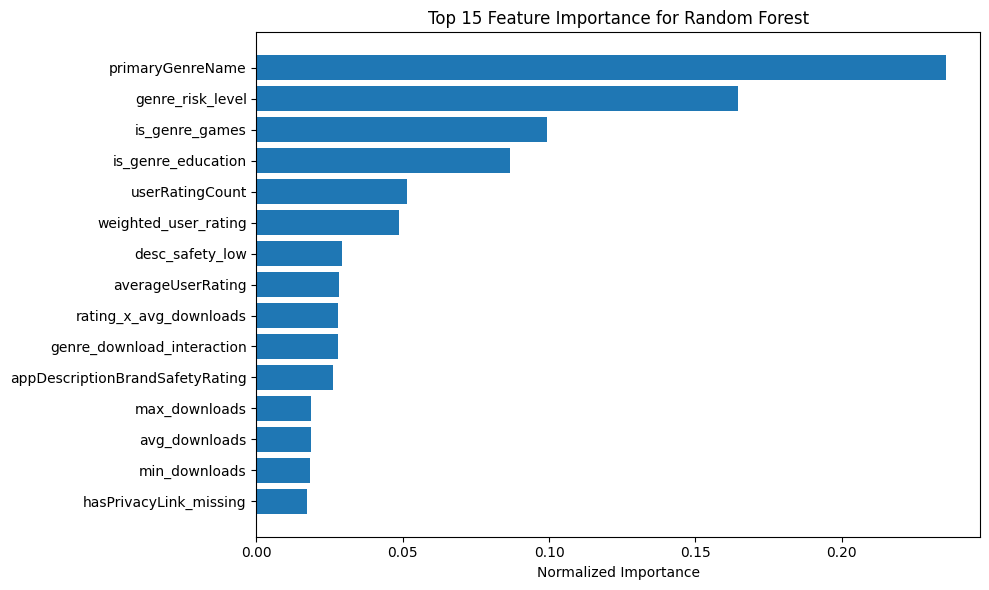


Accuracy:          0.8564
F1 Score (Weight): 0.8712
Recall (Weight):   0.8564
Balanced Accuracy: 0.7411
AUC Score:         0.8838

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92      1261
         1.0       0.36      0.60      0.45       139

    accuracy                           0.86      1400
   macro avg       0.66      0.74      0.68      1400
weighted avg       0.89      0.86      0.87      1400


LightGBM

Top 15 Features:
                                       Feature  Importance
0                              userRatingCount    0.196888
20                        weighted_user_rating    0.123092
6                                min_downloads    0.105924
1                             primaryGenreName    0.081225
4                            averageUserRating    0.076004
21                      rating_x_avg_downloads    0.060743
3                        isCorporateEmailScore    0.037048
7                 

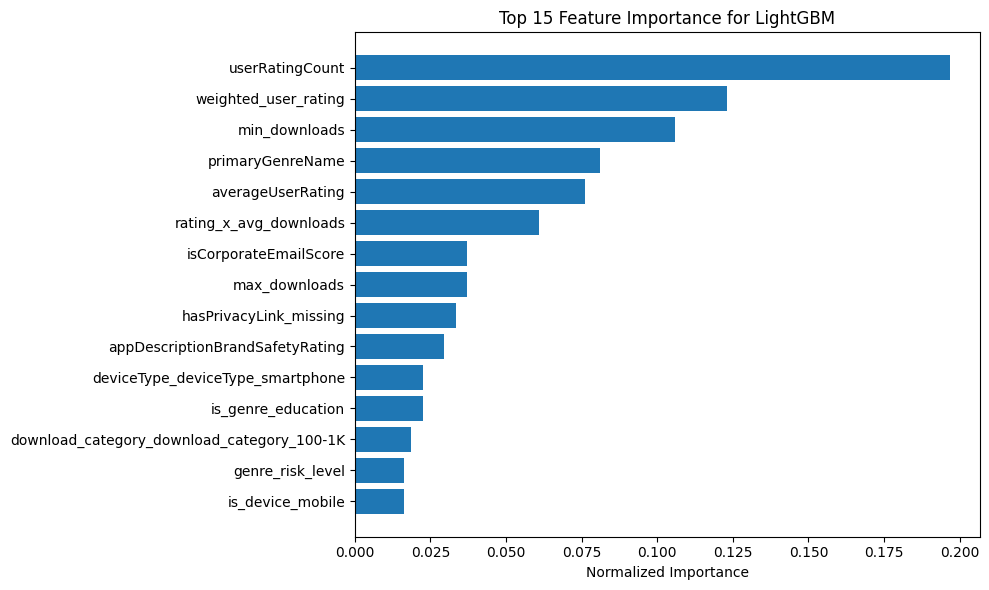


Accuracy:          0.8621
F1 Score (Weight): 0.8749
Recall (Weight):   0.8621
Balanced Accuracy: 0.7378
AUC Score:         0.8833

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92      1261
         1.0       0.38      0.58      0.46       139

    accuracy                           0.86      1400
   macro avg       0.66      0.74      0.69      1400
weighted avg       0.89      0.86      0.87      1400


CatBoost

Top 15 Features:
                             Feature  Importance
18                  genre_risk_level    0.168913
15                is_genre_education    0.114390
16                    is_genre_games    0.111469
1                   primaryGenreName    0.101789
4                  averageUserRating    0.085147
28  deviceType_deviceType_smartphone    0.065300
9             hasPrivacyLink_missing    0.051956
22                   desc_safety_low    0.029251
0                    userRatingCount    0.027075


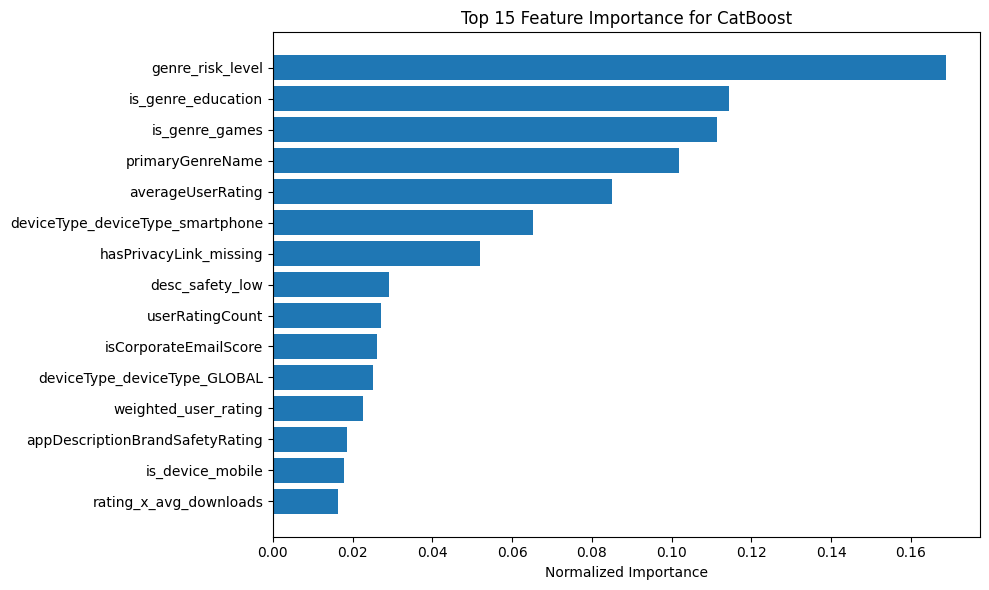


Accuracy:          0.7543
F1 Score (Weight): 0.8024
Recall (Weight):   0.7543
Balanced Accuracy: 0.8348
AUC Score:         0.8896

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.73      0.84      1261
         1.0       0.28      0.94      0.43       139

    accuracy                           0.75      1400
   macro avg       0.63      0.83      0.64      1400
weighted avg       0.92      0.75      0.80      1400


Model Performance Summary (AUC)
CatBoost: 0.889633
Random Forest: 0.883817
LightGBM: 0.883252


In [371]:
# Import necessary models and metrics
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, f1_score, recall_score,
                            balanced_accuracy_score, classification_report,
                            roc_auc_score)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train a model and evaluate its performance with multiple metrics

    Parameters:
    -----------
    model : estimator object
        The model to train and evaluate
    X_train, y_train : array-like
        Training data and labels
    X_val, y_val : array-like
        Validation data and labels
    model_name : str
        Name of the model for display purposes

    Returns:
    --------
    tuple
        Trained model and AUC score
    """
    print("\n" + "="*50)
    print(f"{model_name}")
    print("="*50)

    # Train the model
    model.fit(X_train, y_train)

    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        # Normalize importances to sum to 1 for consistent comparison
        normalized_importances = importances / importances.sum()

        # Create DataFrame for better visualization
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': normalized_importances
        }).sort_values(by='Importance', ascending=False)

        # Display top 15 features
        print("\nTop 15 Features:")
        print(feature_importance_df.head(15))

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df.head(15)['Feature'],
                feature_importance_df.head(15)['Importance'])
        plt.xlabel('Normalized Importance')
        plt.title(f'Top 15 Feature Importance for {model_name}')
        plt.gca().invert_yaxis()  # Display highest importance at the top
        plt.tight_layout()
        plt.show()

    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probability of positive class

    # Calculate metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="weighted")
    recall = recall_score(y_val, y_pred, average="weighted")
    bal_acc = balanced_accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    # Print metrics
    print(f'\nAccuracy:          {acc:.4f}')
    print(f'F1 Score (Weight): {f1:.4f}')
    print(f'Recall (Weight):   {recall:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')
    print(f'AUC Score:         {auc:.4f}')

    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    return model, auc


models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42,
        class_weight='balanced'
    ),

    "LightGBM": LGBMClassifier(
        objective='binary',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=9,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_child_samples=20,
        n_jobs=-1,
        random_state=42,
        is_unbalance=True,
        verbose=-1
    ),

    "CatBoost": CatBoostClassifier(
        iterations=200,
        # iterations=400,
        learning_rate=0.05,
        depth=7,
        l2_leaf_reg=3,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        class_weights=[1,9.06],  # Adjust based on class imbalance ratio
        verbose=0
    )
}

# Evaluate all models
results = {}
for name, model in models.items():
    trained_model, auc_score = evaluate_model(model, X_train, y_train, X_val, y_val, name)
    results[name] = {'model': trained_model, 'auc': auc_score}

# Display results summary
print("\n" + "="*50)
print("Model Performance Summary (AUC)")
print("="*50)
for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
    print(f"{name}: {result['auc']:.6f}")

In [372]:
def select_important_features(X_train, y_train, X_val, threshold=0.01):
    """
    Select important features based on multiple models and a minimum threshold

    Parameters:
    -----------
    X_train : DataFrame
        Training features
    y_train : Series
        Target variable
    X_val : DataFrame
        Validation features
    threshold : float, default=0.01
        Minimum importance threshold for keeping features

    Returns:
    --------
    tuple
        Selected X_train and X_val with only important features
    """
    # Apply SMOTE to training data
    X_train_smote, y_train_smote = my_smote(X_train, y_train)

    print(f"\n{'='*50}")
    print("FEATURE SELECTION")
    print(f"{'='*50}")

    # Train models to get feature importance
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
        'LightGBM': LGBMClassifier(objective='binary', random_state=42, is_unbalance=True, verbose=-1),
        'CatBoost': CatBoostClassifier(iterations=200, random_seed=42, class_weights=[1, 5], verbose=0)
    }

    # Dictionary to store normalized feature importance from each model
    feature_importances = {}

    # Train each model and get feature importances
    for name, model in models.items():
        print(f"\nTraining {name} for feature importance...")
        model.fit(X_train_smote, y_train_smote)

        if hasattr(model, 'feature_importances_'):
            # Normalize importances
            importances = model.feature_importances_
            normalized_importances = importances / importances.sum()

            # Store in dictionary
            feature_importances[name] = pd.Series(normalized_importances, index=X_train.columns)

    # Calculate average importance across models
    all_importances = pd.DataFrame(feature_importances)
    avg_importance = all_importances.mean(axis=1).sort_values(ascending=False)

    print("\nAverage Feature Importance Across Models:")
    for feature, importance in avg_importance.items():
        print(f"{feature:<30} {importance:.6f}")

    # Select features above threshold
    selected_features = avg_importance[avg_importance >= threshold].index.tolist()

    print(f"\nSelected {len(selected_features)} features out of {len(X_train.columns)} (threshold: {threshold}):")
    print(', '.join(selected_features))

    # Return filtered datasets
    return X_train[selected_features], X_val[selected_features], selected_features

# Select important features with threshold 0.01
# X_train_selected, X_val_selected, selected_features = select_important_features(X_train, y_train, X_val, threshold=0.01)
# X_train_selected, X_val_selected, selected_features = select_important_features(X_train, y_train, X_val, threshold=0.005)
X_train_selected, X_val_selected, selected_features = select_important_features(X_train, y_train, X_val, threshold=0.005)



# Evaluate models with selected features
print("\nEvaluating models with selected features:")

# Define model evaluation function
def evaluate_model_with_features(model_class, model_name, X_train, y_train, X_val, y_val, **model_params):
    # Apply SMOTE
    X_train_smote, y_train_smote = my_smote(X_train, y_train)

    # Train model
    model = model_class(**model_params)
    model.fit(X_train_smote, y_train_smote)

    # Evaluate on validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_pred_proba)

    print(f"{model_name} - AUC with selected features: {val_auc:.6f}")
    return model, val_auc

# Evaluate each model with selected features
rf_model, rf_auc = evaluate_model_with_features(
    RandomForestClassifier,
    "Random Forest",
    X_train_selected,
    y_train,
    X_val_selected,
    y_val,
    n_estimators=200,
    max_depth=15,
    random_state=42,
    class_weight='balanced'
)

lgbm_model, lgbm_auc = evaluate_model_with_features(
    LGBMClassifier,
    "LightGBM",
    X_train_selected,
    y_train,
    X_val_selected,
    y_val,
    objective='binary',
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    is_unbalance=True,
    verbose=-1
)

catboost_model, catboost_auc = evaluate_model_with_features(
    CatBoostClassifier,
    "CatBoost",
    X_train_selected,
    y_train,
    X_val_selected,
    y_val,
    iterations=200,
    learning_rate=0.05,
    depth=7,
    random_seed=42,
    class_weights=[1, 9.06],
    verbose=0
)


FEATURE SELECTION

Training Random Forest for feature importance...

Training LightGBM for feature importance...

Training CatBoost for feature importance...

Average Feature Importance Across Models:
primaryGenreName               0.132292
genre_risk_level               0.102505
userRatingCount                0.097334
averageUserRating              0.088840
is_genre_education             0.067631
weighted_user_rating           0.067110
min_downloads                  0.052141
is_genre_games                 0.046526
hasPrivacyLink_missing         0.038904
rating_x_avg_downloads         0.035319
isCorporateEmailScore          0.031037
desc_safety_low                0.027763
deviceType_deviceType_GLOBAL   0.023882
appDescriptionBrandSafetyRating 0.023649
deviceType_deviceType_smartphone 0.023382
is_device_mobile               0.018812
genre_download_interaction     0.016857
avg_downloads                  0.015645
max_downloads                  0.014916
deviceType_deviceType_tablet   0.01

In [373]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

def kfold_cross_validation(model_class, X_train_full, y_train_full, X_val, y_val, n_splits=5, random_state=42, **model_params):
    """
    Perform k-fold cross-validation on training data, then evaluate on validation set

    Parameters:
    -----------
    model_class : class
        The model class to use (e.g., RandomForestClassifier)
    X_train_full, y_train_full : DataFrame, Series
        The full training data (before SMOTE)
    X_val, y_val : DataFrame, Series
        The validation data for final evaluation
    n_splits : int, default=5
        Number of folds for cross-validation
    random_state : int, default=42
        Random seed for reproducibility
    model_params : dict
        Parameters to pass to the model constructor

    Returns:
    --------
    dict
        Results including cv_aucs, mean_cv_auc, val_auc, and final_model
    """
    # Initialize cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_aucs = []

    print(f"\n{'='*50}")
    print(f"K-Fold Cross-Validation for {model_class.__name__}")
    print(f"{'='*50}")

    # Perform cross-validation on training data (before SMOTE)
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_full, y_train_full)):
        # Split data for this fold
        X_fold_train, X_fold_test = X_train_full.iloc[train_idx], X_train_full.iloc[test_idx]
        y_fold_train, y_fold_test = y_train_full.iloc[train_idx], y_train_full.iloc[test_idx]

        # Apply SMOTE only to the training portion of this fold
        X_fold_train_smote, y_fold_train_smote = my_smote(X_fold_train, y_fold_train)

        # Initialize and train model
        model = model_class(**model_params)
        model.fit(X_fold_train_smote, y_fold_train_smote)

        # Evaluate on fold's test data
        y_fold_pred_proba = model.predict_proba(X_fold_test)[:, 1]
        fold_auc = roc_auc_score(y_fold_test, y_fold_pred_proba)
        cv_aucs.append(fold_auc)

        print(f"Fold {fold+1}/{n_splits} - AUC: {fold_auc:.6f}")

    # Display cross-validation results
    mean_cv_auc = np.mean(cv_aucs)
    std_cv_auc = np.std(cv_aucs)
    print(f"\nCross-Validation - Mean AUC: {mean_cv_auc:.6f} (±{std_cv_auc:.6f})")

    # Train final model on the entire SMOTE'd training data
    X_train_smote, y_train_smote = my_smote(X_train_full, y_train_full)
    final_model = model_class(**model_params)
    final_model.fit(X_train_smote, y_train_smote)

    # Evaluate on the separate validation set
    val_pred_proba = final_model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_pred_proba)
    print(f"Validation Set - AUC: {val_auc:.6f}")

    # Return results
    return {
        'cv_aucs': cv_aucs,
        'mean_cv_auc': mean_cv_auc,
        'std_cv_auc': std_cv_auc,
        'val_auc': val_auc,
        'final_model': final_model
    }

# Run k-fold CV for each model
models_to_evaluate = {
    'Random Forest': (RandomForestClassifier, {
        'n_estimators': 200,
        'max_depth': 15,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
        'n_jobs': -1,
        'random_state': 42,
        'class_weight': 'balanced'
    }),

    'LightGBM': (LGBMClassifier, {
        'objective': 'binary',
        'n_estimators': 200,
        'learning_rate': 0.05,
        'max_depth': 9,
        'num_leaves': 63,
        'n_jobs': -1,
        'random_state': 42,
        'is_unbalance': True,
        'verbose': -1
    }),

    'CatBoost': (CatBoostClassifier, {
        'iterations': 200,
        'learning_rate': 0.05,
        'depth': 7,
        'l2_leaf_reg': 3,
        'random_seed': 42,
        'class_weights': [1, 9.06],
        'verbose': 0
    })
}

# Run cross-validation for each model
cv_results = {}
for model_name, (model_class, params) in models_to_evaluate.items():
    cv_results[model_name] = kfold_cross_validation(
        model_class,
        X_train,
        y_train,
        X_val,
        y_val,
        n_splits=5,
        **params
    )

# Print summary of results
print("\n" + "="*50)
print("Model Performance Summary")
print("="*50)
print(f"{'Model':<15} {'CV AUC':<15} {'Validation AUC':<15}")
print("-"*50)
for model_name, results in cv_results.items():
    print(f"{model_name:<15} {results['mean_cv_auc']:.6f} (±{results['std_cv_auc']:.6f}) {results['val_auc']:.6f}")


K-Fold Cross-Validation for RandomForestClassifier
Fold 1/5 - AUC: 0.978460
Fold 2/5 - AUC: 0.981713
Fold 3/5 - AUC: 0.973902
Fold 4/5 - AUC: 0.977859
Fold 5/5 - AUC: 0.977544

Cross-Validation - Mean AUC: 0.977896 (±0.002489)
Validation Set - AUC: 0.883919

K-Fold Cross-Validation for LGBMClassifier
Fold 1/5 - AUC: 0.981029
Fold 2/5 - AUC: 0.983255
Fold 3/5 - AUC: 0.978383
Fold 4/5 - AUC: 0.979220
Fold 5/5 - AUC: 0.980129

Cross-Validation - Mean AUC: 0.980403 (±0.001678)
Validation Set - AUC: 0.882208

K-Fold Cross-Validation for CatBoostClassifier
Fold 1/5 - AUC: 0.960544
Fold 2/5 - AUC: 0.966052
Fold 3/5 - AUC: 0.960578
Fold 4/5 - AUC: 0.963083
Fold 5/5 - AUC: 0.957646

Cross-Validation - Mean AUC: 0.961581 (±0.002822)
Validation Set - AUC: 0.889633

Model Performance Summary
Model           CV AUC          Validation AUC 
--------------------------------------------------
Random Forest   0.977896 (±0.002489) 0.883919
LightGBM        0.980403 (±0.001678) 0.882208
CatBoost        0

In [374]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score

# # Define function to evaluate stacked model with k-fold
# def evaluate_stacked_model(X_train, y_train, X_val, y_val, n_splits=5):
#     # Define base models
#     base_models = [
#         ('rf', RandomForestClassifier(n_estimators=200, max_depth=15,
#                                      random_state=42, class_weight='balanced')),
#         ('lgbm', LGBMClassifier(objective='binary', n_estimators=200,
#                                random_state=42, is_unbalance=True, verbose=-1)),
#         ('catboost', CatBoostClassifier(iterations=200, random_seed=42,
#                                        class_weights=[1, 5], verbose=0))
#     ]

#     # Define the stacking model
#     stacked_model = StackingClassifier(
#         estimators=base_models,
#         final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
#         cv=5,
#         stack_method='predict_proba'
#     )

#     # Perform k-fold CV on the stacked model
#     cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#     cv_aucs = []

#     print(f"\n{'='*50}")
#     print(f"K-Fold Cross-Validation for Stacked Ensemble")
#     print(f"{'='*50}")

#     for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
#         # Split data for this fold
#         X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
#         y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

#         # Apply SMOTE only to the training portion of this fold
#         X_fold_train_smote, y_fold_train_smote = my_smote(X_fold_train, y_fold_train)

#         # Train the stacked model
#         stacked_model.fit(X_fold_train_smote, y_fold_train_smote)

#         # Evaluate on fold's test data
#         y_fold_pred_proba = stacked_model.predict_proba(X_fold_test)[:, 1]
#         fold_auc = roc_auc_score(y_fold_test, y_fold_pred_proba)
#         cv_aucs.append(fold_auc)

#         print(f"Fold {fold+1}/{n_splits} - AUC: {fold_auc:.6f}")

#     # Display cross-validation results
#     mean_cv_auc = np.mean(cv_aucs)
#     std_cv_auc = np.std(cv_aucs)
#     print(f"\nCross-Validation - Mean AUC: {mean_cv_auc:.6f} (±{std_cv_auc:.6f})")

#     # Train final model on the entire SMOTE'd training data
#     X_train_smote, y_train_smote = my_smote(X_train, y_train)
#     stacked_model.fit(X_train_smote, y_train_smote)

#     # Evaluate on the validation set
#     val_pred_proba = stacked_model.predict_proba(X_val)[:, 1]
#     val_auc = roc_auc_score(y_val, val_pred_proba)
#     print(f"Validation Set - AUC: {val_auc:.6f}")

#     return stacked_model, mean_cv_auc, val_auc

# # Run the evaluation
# stacked_model, cv_auc, val_auc = evaluate_stacked_model(X_train, y_train, X_val, y_val)

## 5. Submission